# Pump it Up: Data Mining the Water Table
Using the from <a href='https://taarifa.org/'>Taarifa</a> and the <a href='https://www.maji.go.tz/'>Tanzanian Ministry of Water</a>, I create several models to predict which water pumps are functional or not. To simplify the process, I will only work with two prediction labels: working and not working, and will apply all the underlying processes from a Machine Learning (ML) workflow standpoint. It is also important to understand which metric we are going to maximize, given the nature of the problem. 

I start by introducing the problem, its stakeholders and why is it a relevant and what I am trying to achieve. Then I import the libraries that I am going to use - a combination of pandas and sklearn modules, and then I start basic exploratory data analysis (EDA) and cleaning processes.

From there, we prepare the date and use the training, testing splitting processes so I can inspect how the models will perform on both training and testing data. The notebook will provide three basic Machine Learning models and will also provide a workflow pipeline and an ensemble alternative at the end.

Finally, I wrap up with the conclusion from this exercise and provide some recommendations about what I have discovered. Feel free to criticize, suggest improvements and interact. The dataset comes from DrivenData's Pump it Up: Data Mining the Water Table competition and can be found <a href='https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/'>here</a>.

## Business Problem
Impoverished countries have difficulties in having access to clean water. Water poverty is responsible for a series of illnesses. Anecdotal evidence from the <a href='https://www.tanzaniawaterproject.org/how-were-making-a-difference/water-as-a-word-health-issue/'>Tanzanian Water Project</a> lists that:
<ul>
    <li>1/6 of the world population lack access to safe water;</li>
    <li>88% of the diseases are caused by unsafe water drinking;</li>
    <li>The average American uses 100-175 gallon of water daily, whereas the average African uses 5 gallon of water daily;</li>
    <li>Water poverty negatively impacts education, local economies, agriculture and gender equality.</li>
</ul>
Furthermore, it is estimated that people living in water poverty struck places usually have to walk around 3-5 miles per day to have access to questionable water supply. 

Even though the provided analysis does not solves the issue of lacking water wells in impoverished regions, I posit that having access to the status of a functioning well has its benefits. By having a predictive analysis that shows whether a well is properly functioning or not, public policy efforts can be driven to: fix that well, assess the quality of that well, and provide a better service to communities that use those wells.

The stakeholders are the Tanzanian public policy makers and government, NGO's and the general public - not only the ones that use that well, but all the other communities and people interested. 

## Data Importing and Exploratory Data Analysis

I start by importing the libraries that are going to be used and inspect the DataFrames provided by DrivenData.

In [1]:
# Importing the libraries that are going to be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

# Importing the Datasets from the Tanzania Water Pumping Data Driven's website

# This DataFrame is for the Training Set Labels
df1 = pd.read_csv('csv/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv')

# This DataFrame is for the Test Set Values
df2 = pd.read_csv('csv/702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv')

# This DataFrame is for the Training Set Values
df3 = pd.read_csv('csv/4910797b-ee55-40a7-8668-10efd5c1b960.csv')

# Inspecting df1 - Training Set Labels ('y_train')
df1.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [2]:
# Inspecting df2 - Test Set Values ('X_test'), these are the ones that need to be predicted
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     14850 non-null  int64  
 1   amount_tsh             14850 non-null  float64
 2   date_recorded          14850 non-null  object 
 3   funder                 13981 non-null  object 
 4   gps_height             14850 non-null  int64  
 5   installer              13973 non-null  object 
 6   longitude              14850 non-null  float64
 7   latitude               14850 non-null  float64
 8   wpt_name               14850 non-null  object 
 9   num_private            14850 non-null  int64  
 10  basin                  14850 non-null  object 
 11  subvillage             14751 non-null  object 
 12  region                 14850 non-null  object 
 13  region_code            14850 non-null  int64  
 14  district_code          14850 non-null  int64  
 15  lg

In [3]:
# Inspecting df3 - Training Set Values ('X_train')
df3.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [4]:
# I join the training labels with the 'X_train' dataframe. The motivation behind this procedure is to create a new
# data split, so I can evaluate the performance of the underlying models that I am going to use to predict the labels

df = df1.merge(df3, on = 'id', how = 'inner')


Overall, we have a combination of integer values and objects on the DataFrame's column. We will need to preprocess (i.e scaling) the numerical ones, whereas the categorical ones must pass through an encoding process. Furthermore, a lot of variables seem to be correlated - providing the same information through different features. Let's take as an example the geolocator variables (you can check the list of variables and their characteristics <a href='https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/'>here</a>) and some other features such as the type of extraction and so on.

Let's examine the number of columns with missing values as well.


In [5]:
# Checking the general features of the dataset - a lot of variables with similar names
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   status_group           59400 non-null  object 
 2   amount_tsh             59400 non-null  float64
 3   date_recorded          59400 non-null  object 
 4   funder                 55765 non-null  object 
 5   gps_height             59400 non-null  int64  
 6   installer              55745 non-null  object 
 7   longitude              59400 non-null  float64
 8   latitude               59400 non-null  float64
 9   wpt_name               59400 non-null  object 
 10  num_private            59400 non-null  int64  
 11  basin                  59400 non-null  object 
 12  subvillage             59029 non-null  object 
 13  region                 59400 non-null  object 
 14  region_code            59400 non-null  int64  
 15  di

We can see there are a few missing rows, specially for scheme_name. Other variables with missing values are: funder, subvillage, public_meeting, scheme_management and permit. According to <a href='https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/'>Driven Data's website</a> the variables funder represents who funded the well, subvillage is a geolocation variable, public_meeting is a boolean value (True/False) which might indicate whether there are public meetings, scheme_name and scheme_management illustrates who operates the waterpoint and permit yields whether the point has a permit. 

I argue that subvillage can be dropped without any compromise to the analysis, given that we have other geolocation variables that might be correlated with subvillage. The variables scheme_name and scheme_management are also correlated, since both indicate who operates the waterpoint - so I drop the one with fewer entries (scheme_name).

The other variables are kept, since there isn't a huge loss to the number of rows.


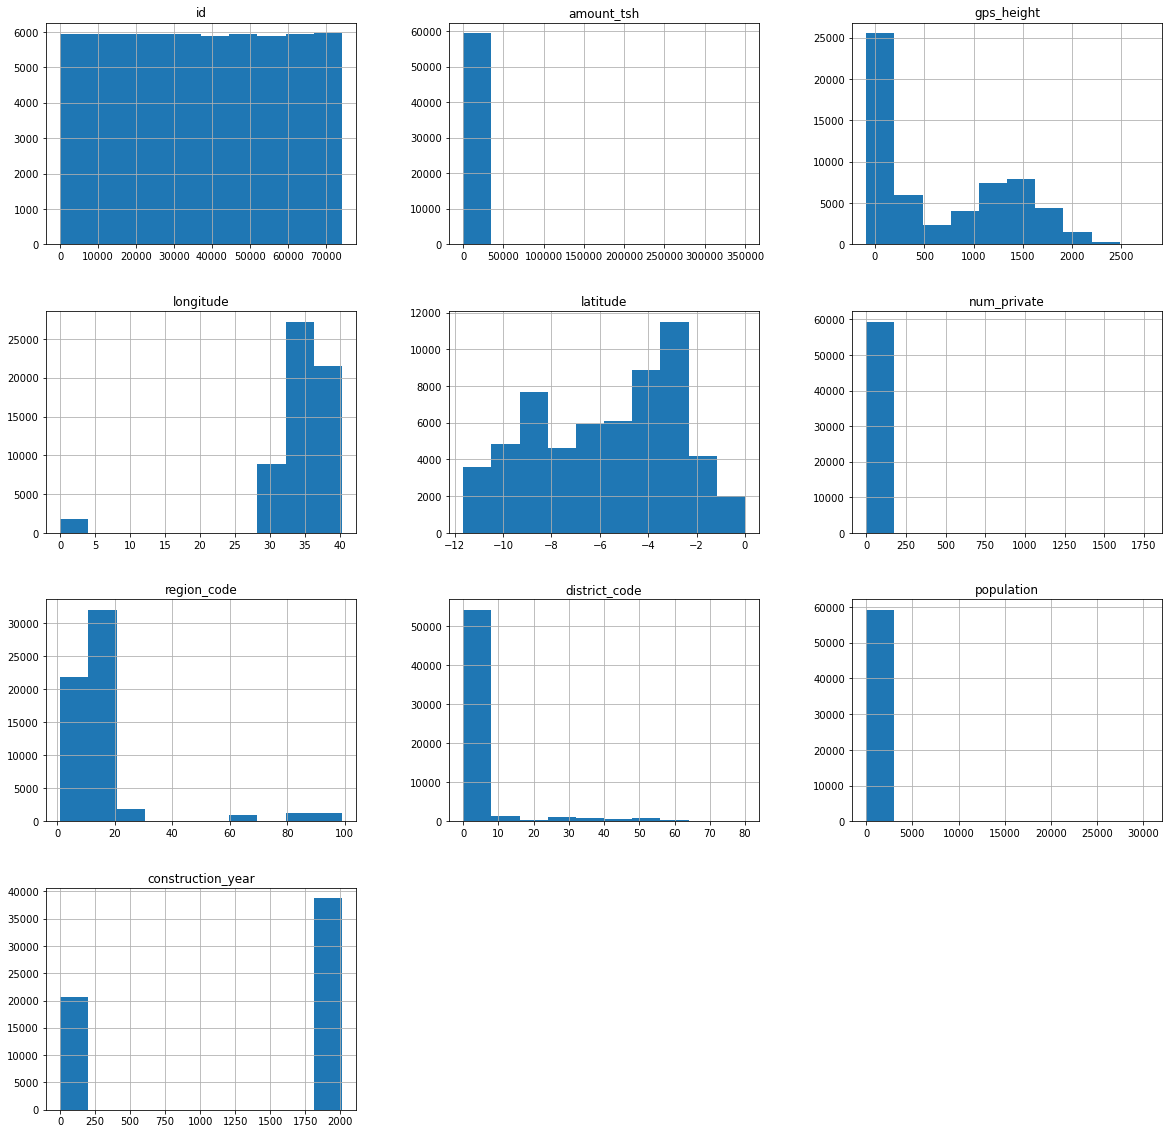

In [6]:
# Plotting an histogram
ax = df.hist(figsize = (20, 20))
plt.show()

In [7]:
# Checking quantity and quantity group - they're all the same
print('Checking quantity and quantity_group overlap: \n',(df['quantity'] == df['quantity_group']).value_counts())
print('\n')

# Checking waterpoint_type and waterpoint_type_group - they're almost all the same, however there is a small
# number of entries that are different (~10%) - I will drop it since it won't provide much difference to the models
print('Checking waterpoint_type and waterpoint_type overlap: \n',(df['waterpoint_type'] == df['waterpoint_type_group']).value_counts())
print('\n')

# Checking source and source_type group - almost 50-50 - Will investigate further
print('Checking source and source_type overlap: \n',((df['source'] == df['source_type']).value_counts()))
print('\n')

# Checking source_type and source_class group - they are not the same, so I can drop type since it overlaps with
print('Checking source_type and source_class overlap: \n',((df['source_type'] == df['source_class']).value_counts()))
print('\n')

# Checking payment and payment_type group - huge overlap
print('Checking payment and payment_type overlap: \n', ((df['payment'] == df['payment_type']).value_counts()))
print('\n')

# Checking funder and installer group - no overlap
print('Checking funder and installer overlap: \n', ((df['funder'] == df['installer']).value_counts()))

Checking quantity and quantity_group overlap: 
 True    59400
dtype: int64


Checking waterpoint_type and waterpoint_type overlap: 
 True     53297
False     6103
dtype: int64


Checking source and source_type overlap: 
 True     37008
False    22392
dtype: int64


Checking source_type and source_class overlap: 
 False    59400
dtype: int64


Checking payment and payment_type overlap: 
 True     34559
False    24841
dtype: int64


Checking funder and installer overlap: 
 False    53704
True      5696
dtype: int64


In [8]:
# Dropping overlapping variables
df = df.drop(['scheme_name', 'payment', 'quantity_group', 'waterpoint_type_group'], axis = 1)

# Checking management and management_group. The management variables seems more granular
df[['management', 'management_group']].value_counts()

management        management_group
vwc               user-group          40507
wug               user-group           6515
water board       user-group           2933
wua               user-group           2535
private operator  commercial           1971
parastatal        parastatal           1768
water authority   commercial            904
other             other                 844
company           commercial            685
unknown           unknown               561
other - school    other                  99
trust             commercial             78
dtype: int64

### Data Cleaning: Initial Steps
I start investigating columns with similar names and their values. If variables provide similar estimates they can be deemed as correlated. A high correlation among these variables may introduce noise and provide more problems than solutions to our predictive analysis.

The procedures below tackle this issue and provides some reasonable solutions in circumventing such issues. You can find comments illustrating the rationale behind each of the steps undertaken.


In [9]:
# Half of the difference comes out of machine dbh and borehole, let's inspect the rest
print('Number of rows where source is equal to machine dbh and source_type is equal to borehole:',len(df[(df['source'] == 'machine dbh') & (df['source_type'] == 'borehole')]))


Number of rows where source is equal to machine dbh and source_type is equal to borehole: 11075


In [10]:
# Different source and source_type
df_diff = df[df['source'] != df['source_type']]

# Then filtering - it seems that river/lake is the other thing that stands in the way - we can drop it
df_diff.loc[df_diff['source'] != 'machine dbh'][['source', 'source_type']]

,source,source_type
16,river,river/lake
17,river,river/lake
22,river,river/lake
23,river,river/lake
31,river,river/lake
...,...,...
59369,river,river/lake
59370,unknown,other
59375,river,river/lake
59391,river,river/lake


In [11]:
# Checking water_quality and quality_group - there is a clear overlap between variables
df[['water_quality', 'quality_group']].value_counts()


water_quality       quality_group
soft                good             50818
salty               salty             4856
unknown             unknown           1876
milky               milky              804
coloured            colored            490
salty abandoned     salty              339
fluoride            fluoride           200
fluoride abandoned  fluoride            17
dtype: int64

In [12]:
# Checking extraction type - clear overlap. I'll keep extraction_type_class
df[['extraction_type', 'extraction_type_group', 'extraction_type_class']].value_counts()

# Dropping the last overlapping columns from above
df = df.drop(['source_type', 'water_quality', 'extraction_type', 'extraction_type_group', 'management_group'], axis = 1)

In [13]:
# Substituting functional needs repair to functional. It seems fairly balanced, we won't need SMOTE
df.loc[df.status_group == 'functional needs repair', 'status_group'] = 'functional'

# Almost 60-40%.
df['status_group'].value_counts(normalize = True)

functional        0.615758
non functional    0.384242
Name: status_group, dtype: float64

In [14]:
# Setting the DataFrame index
df = df.set_index('id')

# Checking the population variable - seems like it is empty, I can drop it
df['population'].value_counts()

0       21381
1        7025
200      1940
150      1892
250      1681
        ...  
3241        1
1960        1
1685        1
2248        1
1439        1
Name: population, Length: 1049, dtype: int64

In [15]:
# Checking gps_heigt - most variables look like they'are zeros. I will drop them
df['gps_height'].value_counts()

 0       20438
-15         60
-16         55
-13         55
-20         52
         ...  
 2285        1
 2424        1
 2552        1
 2413        1
 2385        1
Name: gps_height, Length: 2428, dtype: int64

In [16]:
# Checking the geolocation variables for any overlap
df[['lga', 'ward', 'basin', 'region', 'region_code', 'district_code', 'subvillage']].value_counts()

lga           ward       basin                    region         region_code  district_code  subvillage          
Ilala         Kitunda    Wami / Ruvu              Dar es Salaam  7            2              Mtaa Wa Kitunda Kati    84
Arusha Rural  Nduruma    Pangani                  Arusha         2            2              Marurani Kati           59
                                                                                             Marurani Juu            54
Ilala         Chanika    Wami / Ruvu              Dar es Salaam  7            2              Mtaa Wa Vikongoro       47
Kibaha        Soga       Wami / Ruvu              Pwani          6            2              Vikuge                  41
                                                                                                                     ..
Sikonge       Sikonge    Lake Tanganyika          Tabora         14           5              Iyombakuzoa              1
Masasi        Lukulendi  Ruvuma / Southern Coa

In [17]:
# Checking subvillage and ward. They seem to be both very granular
df[['subvillage', 'ward']].value_counts()

subvillage            ward   
Mtaa Wa Kitunda Kati  Kitunda    84
Marurani Kati         Nduruma    59
Marurani Juu          Nduruma    54
Mtaa Wa Vikongoro     Chanika    47
Vikuge                Soga       41
                                 ..
Minazini              Itete       1
                      Kalulu      1
                      Luchili     1
                      Mahenge     1
##                    Izimbya     1
Length: 27470, dtype: int64

In [18]:
# Checking construction_year variable. A lot of 0's
df['construction_year'].value_counts()

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: construction_year, dtype: int64

In [19]:
# Checking region_code and district_code overlap - looks fine
df[['region_code', 'district_code']].value_counts()

region_code  district_code
11           4                2476
17           3                1401
             1                1251
3            4                1225
2            2                1206
                              ... 
6            6                  26
1            0                  23
17           80                 12
60           67                  6
40           43                  1
Length: 130, dtype: int64

In [20]:
# num_private - no clear description of the variable and full of zeros. I will drop it
df['num_private'].value_counts()

# Dropping what I won't use. The variable recorded_by lists the name of the company that provided the dataset
df = df.drop(['num_private', 'latitude', 'longitude', 'recorded_by', 'subvillage', 'population', 'gps_height'], axis = 1)

In [21]:
# 70% of wells have no water available... this should be a strong predictor of not functioning
print(df['amount_tsh'].value_counts(normalize = True))


0.0         0.700993
500.0       0.052222
50.0        0.041616
1000.0      0.025051
20.0        0.024630
              ...   
8500.0      0.000017
6300.0      0.000017
220.0       0.000017
138000.0    0.000017
12.0        0.000017
Name: amount_tsh, Length: 98, dtype: float64


In [22]:
# However, once we cross that date with quantity, it seems odd
df[['quantity', 'amount_tsh']]


,quantity,amount_tsh
id,,
69572,enough,6000.0
8776,insufficient,0.0
34310,enough,25.0
67743,dry,0.0
19728,seasonal,0.0
...,...,...
60739,enough,10.0
27263,enough,4700.0
37057,enough,0.0


In [23]:
# Checking amount_tsh - doesn't seem like a consistent predictor. The value is set to zero and has more
# than enough water...
df[df['amount_tsh'] == 0.0]['quantity'].value_counts(normalize = True)

# Dropping it
df = df.drop('amount_tsh', axis = 1)

### Data Cleaning: Final Steps
The steps above indicate processes where I checked variable overlapping and some data cleansing procedures so we can start working with our models. First, I checked which variables had overlapping or similar values, such as: extraction_type, extraction_type_group, extraction_type_class, water_quality, quality_group, source_type, source_type_class and source_type_group.

Across the board, it is visible that some of these variables provide similar variables with almost no different entry. By examining these columns, and dropping following the logic depicted above we are able to avoid multicollinearity of features.

I also examine the set of numerical variables from the dataset. From inspecting the columns, we see that num_private is filled with zeroes and will not provide much variation to our prediction. The construction number also has  considerable values set as zero (maybe missing?) and they certainly will need to be encoded as dummy variables. Population also does not provide too much useful information.

Furthermore, since this exercise will try to predict whether a pump is functioning or not, I substitute pumps categorized as 'functional needs repair' to 'functional'. The next steps will be encoding the categorical variables and scaling the numerical variables so we can work on a same scale.

In [24]:
# Turning 'numerical' variables into strings
for var in list(df.columns):
    df[var] = df[var].astype('str')

# Starting pipeline process
pipe = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'constant', fill_value = 'missing')),
                                 ('encoder', OneHotEncoder(handle_unknown = 'ignore')), 
                         ('dct', DecisionTreeClassifier(random_state = 42, max_depth = 5, criterion = 'entropy'))])
# Generating Y's and X's
y = df['status_group']
X = df.drop('status_group', axis = 1)

# Train-Test-Split - test_size = 0.25 and random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.25)

# Fitting our pipeline and retrieving the score                         
pipe.fit(X_train, y_train)
pipe.score(X_train, y_train)

0.7737149270482604

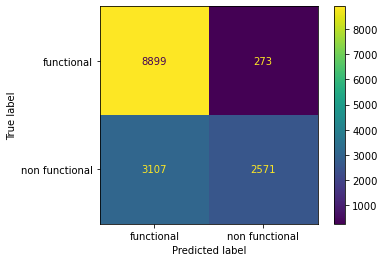

In [25]:
# Creating a confusing matrix to check the consistency of the model with testing data
plot_confusion_matrix(pipe, X_test, y_test);

In [26]:
# Generating the predictions
y_pred = pipe.predict(X_test)

# Then printing the classification_report
print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

    functional       0.74      0.97      0.84      9172
non functional       0.90      0.45      0.60      5678

      accuracy                           0.77     14850
     macro avg       0.82      0.71      0.72     14850
  weighted avg       0.80      0.77      0.75     14850



In [27]:
# Building a GridSearchCV framework - we start with the parameters
param_grid = {
    'dct__criterion': ['gini', 'entropy'],
    'dct__max_depth': [3, 5, 7, 9],
    'dct__min_samples_leaf': [3, 6, 9],
    'dct__min_samples_split': [3, 5, 10, 15]
}

# Instantiating the GridSearch
grid_search = GridSearchCV(pipe, param_grid = param_grid, cv = 3, return_train_score = True, n_jobs = 2)

# Fitting to our data
grid_search.fit(X_train, y_train)

# Printing out the Results
print(f"Training Accuracy: {grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {grid_search.best_params_}")

Training Accuracy: 80.10%

Optimal Parameters: {'dct__criterion': 'gini', 'dct__max_depth': 9, 'dct__min_samples_leaf': 3, 'dct__min_samples_split': 15}


In [28]:
# Let's try a more sophisticated model by creating a new pipeline - RandomForestClassifier
new_pipe = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'constant', fill_value = 'missing')),
                                 ('encoder', OneHotEncoder(handle_unknown = 'ignore')), 
                         ('rft', RandomForestClassifier(random_state = 42))])

# Fitting and scoring our new pipe
new_pipe.fit(X_train, y_train)
new_pipe.score(X_train, y_train)

0.9945005611672278

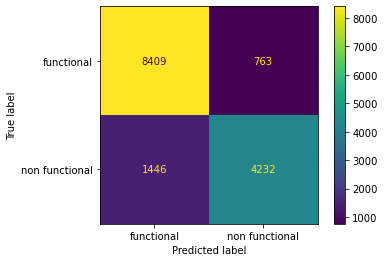

In [29]:
# Creating a confusing matrix to check the consistency of the model with testing data
plot_confusion_matrix(new_pipe, X_test, y_test);

In [30]:
# Generating the predictions
y_pred = new_pipe.predict(X_test)

# Then printing the classification_report
print(classification_report(y_test, y_pred))

# Creating a new GridSearchCV
rf_param_grid = {
    'rft__criterion': ['gini', 'entropy'],
    'rft__max_depth': [3, 5, 7, 9],
    'rft__min_samples_leaf': [3, 6, 9],
    'rft__min_samples_split': [3, 5, 10, 15]
}

# Instantiating the GridSearch
rf_grid_search = GridSearchCV(new_pipe, rf_param_grid, cv = 3, return_train_score = True, n_jobs = 2)

# Fitting to our data
rf_grid_search.fit(X_train, y_train)

# Printing out the Results
print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

                precision    recall  f1-score   support

    functional       0.85      0.92      0.88      9172
non functional       0.85      0.75      0.79      5678

      accuracy                           0.85     14850
     macro avg       0.85      0.83      0.84     14850
  weighted avg       0.85      0.85      0.85     14850

Training Accuracy: 64.32%

Optimal Parameters: {'rft__criterion': 'entropy', 'rft__max_depth': 9, 'rft__min_samples_leaf': 3, 'rft__min_samples_split': 10}


In [31]:
# Final Scores
print('Decision Tree Grid Search:', grid_search.score(X_test, y_test))
print('Random Forest Grid Search:', rf_grid_search.score(X_test, y_test))


Decision Tree Grid Search: 0.796969696969697
Random Forest Grid Search: 0.6332659932659933
